In [2]:
# NLI(Natural Language Interference:자연어 추론) 훈련 예제
#
# => input_ids : [CLS]senetence1(전제)[SEP]sentence2(가설)
# => attention_mask : 1111111111(전체,가설)0000000(그외)
# => token_type_ids : 0000000(전제)1111111(가설)00000000(그외)
# => laels : 참(수반:entailment), 거짓(모순:contradiction), 모름(중립:neutral)

import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from os import sys
sys.path.append('..')
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm
import os

logger = mlogging(loggername="bertfttrain", logfilename="bertftmultitrain")
device = GPU_info()
seed_everything(111)

logfilepath:bertftmultitrain_2022-03-28.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [4]:
#############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

model_path = 'model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/'
vocab_path = 'model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/'
OUTPATH = 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-ft-nli-0328/'

# tokeniaer 및 model 설정
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
#tokenizer = BertTokenizer(vocab_file=vocab_path, strip_accents=False, do_lower_case=False) 
tokenizer = BertTokenizer.from_pretrained(vocab_path, do_lower_case=False)

# NLI 모델에서 레벨은 3개지(참,거짓,모름) 이므로, num_labels=3을 입력함
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)
#model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=6)

# 레벨을 멀티로 선택해야 하는 경우
#model = BertForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification",num_labels=6)
                   
#기존 모델 파일을 로딩하는 경우    
#model = torch.load(model_path) 

model.to(device)

Some weights of the model checkpoint at model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/ were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the mod

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(167550, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [5]:
model.num_parameters()

214722051

In [8]:
# 학습 data loader 생성
sys.path.append('..')
from myutils import ClassificationDataset, KlueNLICorpus, data_collator
from torch.utils.data import DataLoader, RandomSampler

#############################################################################
# 변수 설정
#############################################################################
max_seq_len = 128   # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
batch_size = 16        # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)

# 훈련할 csv 파일
file_fpath = 'korpora/klue-nli/klue-nli-v1.1_train.json'
#file_fpath = 'Korpora/nsmc/ratings_train.txt'
cache = True   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)
#############################################################################

# corpus 파일 설정
corpus = KlueNLICorpus()

# 학습 dataset 생성
dataset = ClassificationDataset(file_fpath=file_fpath,max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)


# 학습 dataloader 생성
train_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성
file_fpath = 'korpora/klue-nli/klue-nli-v1.1_dev.json'
dataset = ClassificationDataset(file_fpath=file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

# 평가 dataloader 생성
eval_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

print('train_loader_len: {}, eval_loader_len: {}'.format(len(train_loader), len(eval_loader)))

2022-03-28 15:58:32,911 - bwpdataset - INFO - Creating features from dataset file at korpora/klue-nli/klue-nli-v1.1_train.json
2022-03-28 15:58:32,913 - bwpdataset - INFO - loading data... LOOKING AT korpora/klue-nli/klue-nli-v1.1_train.json
2022-03-28 15:58:33,305 - bwpdataset - INFO - tokenize sentences, it could take a lot of time...
2022-03-28 15:58:40,609 - bwpdataset - INFO - tokenize sentences [took 7.303 s]


  0%|          | 0/24998 [00:00<?, ?it/s]

2022-03-28 15:58:40,674 - bwpdataset - INFO - *** Example ***
2022-03-28 15:58:40,676 - bwpdataset - INFO - sentence A, B: 힛걸 진심 최고다 그 어떤 히어로보다 멋지다 + 힛걸 진심 최고로 멋지다.
2022-03-28 15:58:40,676 - bwpdataset - INFO - tokens: [CLS] [UNK] 진심 최고 ##다 그 어떤 히어로 ##보다 멋 ##지 ##다 [SEP] [UNK] 진심 최고 ##로 멋 ##지 ##다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
2022-03-28 15:58:40,677 - bwpdataset - INFO - label: entail

  0%|          | 0/3000 [00:00<?, ?it/s]

2022-03-28 15:58:43,432 - bwpdataset - INFO - *** Example ***
2022-03-28 15:58:43,433 - bwpdataset - INFO - sentence A, B: 흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다. + 어떤 방에서도 흡연은 금지됩니다.
2022-03-28 15:58:43,434 - bwpdataset - INFO - tokens: [CLS] 흡연자 ##분 ##들은 발코니 ##가 있는 방이 ##면 발코니 ##에서 흡연 ##이 가능 ##합 ##니다 . [SEP] 어떤 방 ##에서 ##도 흡연 ##은 [UNK] . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
2022-03-28 15:58:43,435 - bwpdataset - INFO - label:

train_loader_len: 1563, eval_loader_len: 188


In [9]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다", "정말 재미있다"))
print(tokenizer.convert_ids_to_tokens(131027))
print(tokenizer.convert_tokens_to_ids('정말'))

167550
[101, 9034, 10530, 124997, 11018, 125215, 10739, 69708, 42428, 10459, 10020, 129937, 10892, 132489, 12508, 49137, 102, 9670, 89523, 125551, 76820, 102]
최치원
100


In [10]:
# 학습 시작
import time

logger.info(f"=== model: {model_path} ===")
logger.info(f"num_parameters: {model.num_parameters()}")

##################################################
# 변수 설정
##################################################
epochs = 10            # epochs
learning_rate = 2e-5  # 학습률
p_itr = 200           # 손실률 보여줄 step 수
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

num_warmup_steps = total_steps * 0.1

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 정확도와 총 손실률 계산
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break
   
    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    start = time.time()
    logger.info(f'---------------------------------------------------------')

    # 평가 시작
    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
 
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=labels)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            #loss = outputs.loss
            logits = outputs.logits
    
            # 총 손실류 구함
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_test_correct += correct.sum().item()
            total_test_len += len(labels)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    logger.info(f'---------------------------------------------------------')
    logger.info(f'=== 처리시간: {time.time() - start:.3f} 초 ===')
    logger.info(f'-END-\n')
    ####################################################################
    

2022-03-28 16:01:24,330 - bertfttrain - INFO - === model: model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/ ===
2022-03-28 16:01:24,335 - bertfttrain - INFO - num_parameters: 214722051


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

/tmp/ipykernel_23523/2764082033.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-03-28 16:01:48,194 - bertfttrain - INFO - [Epoch 1/10] Iteration 200 -> Train Loss: 1.1005, Train Accuracy: 0.349
2022-03-28 16:02:10,433 - bertfttrain - INFO - [Epoch 1/10] Iteration 400 -> Train Loss: 1.0979, Train Accuracy: 0.357
2022-03-28 16:02:34,086 - bertfttrain - INFO - [Epoch 1/10] Iteration 600 -> Train Loss: 0.9981, Train Accuracy: 0.505
2022-03-28 16:02:59,270 - bertfttrain - INFO - [Epoch 1/10] Iteration 800 -> Train Loss: 0.8528, Train Accuracy: 0.628
2022-03-28 16:03:22,605 - bertfttrain - INFO - [Epoch 1/10] Iteration 1000 -> Train Loss: 0.8359, Train Accuracy: 0.639
2022-03-28 16:03:45,135 - bertfttrain - INFO - [Epoch 1/10] Iteration 1200 -> Train Loss: 0.8074, Train Accuracy: 0.653
2022-03-28 16:04:07,575 - bertfttrain - INFO - [Epoch 1/10] Iteration 1400 -

  0%|          | 0/188 [00:00<?, ?it/s]

/tmp/ipykernel_23523/2764082033.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-03-28 16:04:30,701 - bertfttrain - INFO - [Epoch 1/10] Validatation Accuracy:0.6316666666666667
2022-03-28 16:04:30,703 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:04:30,703 - bertfttrain - INFO - === 처리시간: 4.287 초 ===
2022-03-28 16:04:30,704 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:04:35,555 - bertfttrain - INFO - [Epoch 2/10] Iteration 1600 -> Train Loss: 0.7385, Train Accuracy: 0.691
2022-03-28 16:05:01,881 - bertfttrain - INFO - [Epoch 2/10] Iteration 1800 -> Train Loss: 0.6702, Train Accuracy: 0.723
2022-03-28 16:05:24,411 - bertfttrain - INFO - [Epoch 2/10] Iteration 2000 -> Train Loss: 0.6418, Train Accuracy: 0.743
2022-03-28 16:05:46,931 - bertfttrain - INFO - [Epoch 2/10] Iteration 2200 -> Train Loss: 0.6477, Train Accuracy: 0.734
2022-03-28 16:06:09,506 - bertfttrain - INFO - [Epoch 2/10] Iteration 2400 -> Train Loss: 0.6134, Train Accuracy: 0.758
2022-03-28 16:06:31,939 - bertfttrain - INFO - [Epoch 2/10] Iteration 2600 -> Train Loss: 0.6222, Train Accuracy: 0.746
2022-03-28 16:06:54,490 - bertfttrain - INFO - [Epoch 2/10] Iteration 2800 -> Train Loss: 0.6210, Train Accuracy: 0.753
2022-03-28 16:07:17,030 - bertfttrain - INFO - [Epoch 2/10] Iteration 3000 -> Train Loss: 0.5949, Train Accuracy: 0.764
2022-03-28 16:07:31,420 - bertfttrain - 

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:07:35,588 - bertfttrain - INFO - [Epoch 2/10] Validatation Accuracy:0.6923333333333334
2022-03-28 16:07:35,590 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:07:35,591 - bertfttrain - INFO - === 처리시간: 4.171 초 ===
2022-03-28 16:07:35,592 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:07:44,313 - bertfttrain - INFO - [Epoch 3/10] Iteration 3200 -> Train Loss: 0.5570, Train Accuracy: 0.782
2022-03-28 16:08:06,851 - bertfttrain - INFO - [Epoch 3/10] Iteration 3400 -> Train Loss: 0.4135, Train Accuracy: 0.844
2022-03-28 16:08:29,270 - bertfttrain - INFO - [Epoch 3/10] Iteration 3600 -> Train Loss: 0.4531, Train Accuracy: 0.826
2022-03-28 16:08:51,773 - bertfttrain - INFO - [Epoch 3/10] Iteration 3800 -> Train Loss: 0.4362, Train Accuracy: 0.840
2022-03-28 16:09:16,939 - bertfttrain - INFO - [Epoch 3/10] Iteration 4000 -> Train Loss: 0.4425, Train Accuracy: 0.835
2022-03-28 16:09:39,405 - bertfttrain - INFO - [Epoch 3/10] Iteration 4200 -> Train Loss: 0.4075, Train Accuracy: 0.851
2022-03-28 16:10:01,961 - bertfttrain - INFO - [Epoch 3/10] Iteration 4400 -> Train Loss: 0.4313, Train Accuracy: 0.842
2022-03-28 16:10:24,534 - bertfttrain - INFO - [Epoch 3/10] Iteration 4600 -> Train Loss: 0.4210, Train Accuracy: 0.837
2022-03-28 16:10:34,778 - bertfttrain - 

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:10:38,975 - bertfttrain - INFO - [Epoch 3/10] Validatation Accuracy:0.6986666666666667
2022-03-28 16:10:38,977 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:10:38,978 - bertfttrain - INFO - === 처리시간: 4.200 초 ===
2022-03-28 16:10:38,979 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:10:54,131 - bertfttrain - INFO - [Epoch 4/10] Iteration 4800 -> Train Loss: 0.3373, Train Accuracy: 0.879
2022-03-28 16:11:17,772 - bertfttrain - INFO - [Epoch 4/10] Iteration 5000 -> Train Loss: 0.2693, Train Accuracy: 0.908
2022-03-28 16:11:40,521 - bertfttrain - INFO - [Epoch 4/10] Iteration 5200 -> Train Loss: 0.2858, Train Accuracy: 0.898
2022-03-28 16:12:03,052 - bertfttrain - INFO - [Epoch 4/10] Iteration 5400 -> Train Loss: 0.2988, Train Accuracy: 0.897
2022-03-28 16:12:25,766 - bertfttrain - INFO - [Epoch 4/10] Iteration 5600 -> Train Loss: 0.3125, Train Accuracy: 0.893
2022-03-28 16:12:52,218 - bertfttrain - INFO - [Epoch 4/10] Iteration 5800 -> Train Loss: 0.2747, Train Accuracy: 0.899
2022-03-28 16:13:15,525 - bertfttrain - INFO - [Epoch 4/10] Iteration 6000 -> Train Loss: 0.2981, Train Accuracy: 0.897
2022-03-28 16:13:38,206 - bertfttrain - INFO - [Epoch 4/10] Iteration 6200 -> Train Loss: 0.2908, Train Accuracy: 0.899
2022-03-28 16:13:44,208 - bertfttrain - 

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:13:48,392 - bertfttrain - INFO - [Epoch 4/10] Validatation Accuracy:0.7106666666666667
2022-03-28 16:13:48,393 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:13:48,394 - bertfttrain - INFO - === 처리시간: 4.186 초 ===
2022-03-28 16:13:48,394 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:14:05,305 - bertfttrain - INFO - [Epoch 5/10] Iteration 6400 -> Train Loss: 0.2554, Train Accuracy: 0.913
2022-03-28 16:14:29,623 - bertfttrain - INFO - [Epoch 5/10] Iteration 6600 -> Train Loss: 0.1911, Train Accuracy: 0.938
2022-03-28 16:14:53,040 - bertfttrain - INFO - [Epoch 5/10] Iteration 6800 -> Train Loss: 0.2026, Train Accuracy: 0.941
2022-03-28 16:15:15,479 - bertfttrain - INFO - [Epoch 5/10] Iteration 7000 -> Train Loss: 0.1990, Train Accuracy: 0.934
2022-03-28 16:15:37,297 - bertfttrain - INFO - [Epoch 5/10] Iteration 7200 -> Train Loss: 0.2066, Train Accuracy: 0.938
2022-03-28 16:16:02,904 - bertfttrain - INFO - [Epoch 5/10] Iteration 7400 -> Train Loss: 0.2090, Train Accuracy: 0.936
2022-03-28 16:16:24,833 - bertfttrain - INFO - [Epoch 5/10] Iteration 7600 -> Train Loss: 0.2235, Train Accuracy: 0.927
2022-03-28 16:16:47,534 - bertfttrain - INFO - [Epoch 5/10] Iteration 7800 -> Train Loss: 0.2150, Train Accuracy: 0.930
2022-03-28 16:16:49,703 - bertfttrain - 

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:16:53,896 - bertfttrain - INFO - [Epoch 5/10] Validatation Accuracy:0.7106666666666667
2022-03-28 16:16:53,898 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:16:53,900 - bertfttrain - INFO - === 처리시간: 4.197 초 ===
2022-03-28 16:16:53,901 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:17:16,055 - bertfttrain - INFO - [Epoch 6/10] Iteration 8000 -> Train Loss: 0.1311, Train Accuracy: 0.961
2022-03-28 16:17:42,107 - bertfttrain - INFO - [Epoch 6/10] Iteration 8200 -> Train Loss: 0.1598, Train Accuracy: 0.958
2022-03-28 16:18:06,305 - bertfttrain - INFO - [Epoch 6/10] Iteration 8400 -> Train Loss: 0.1363, Train Accuracy: 0.963
2022-03-28 16:18:29,075 - bertfttrain - INFO - [Epoch 6/10] Iteration 8600 -> Train Loss: 0.1800, Train Accuracy: 0.954
2022-03-28 16:18:51,306 - bertfttrain - INFO - [Epoch 6/10] Iteration 8800 -> Train Loss: 0.1913, Train Accuracy: 0.952
2022-03-28 16:19:14,139 - bertfttrain - INFO - [Epoch 6/10] Iteration 9000 -> Train Loss: 0.1783, Train Accuracy: 0.953
2022-03-28 16:19:37,234 - bertfttrain - INFO - [Epoch 6/10] Iteration 9200 -> Train Loss: 0.1612, Train Accuracy: 0.959
2022-03-28 16:19:58,931 - bertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:20:03,141 - bertfttrain - INFO - [Epoch 6/10] Validatation Accuracy:0.7043333333333334
2022-03-28 16:20:03,144 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:20:03,145 - bertfttrain - INFO - === 처리시간: 4.214 초 ===
2022-03-28 16:20:03,146 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:20:05,972 - bertfttrain - INFO - [Epoch 7/10] Iteration 9400 -> Train Loss: 0.1784, Train Accuracy: 0.954
2022-03-28 16:20:27,648 - bertfttrain - INFO - [Epoch 7/10] Iteration 9600 -> Train Loss: 0.1155, Train Accuracy: 0.972
2022-03-28 16:20:50,147 - bertfttrain - INFO - [Epoch 7/10] Iteration 9800 -> Train Loss: 0.1282, Train Accuracy: 0.969
2022-03-28 16:21:13,934 - bertfttrain - INFO - [Epoch 7/10] Iteration 10000 -> Train Loss: 0.0947, Train Accuracy: 0.974
2022-03-28 16:21:33,994 - bertfttrain - INFO - [Epoch 7/10] Iteration 10200 -> Train Loss: 0.1371, Train Accuracy: 0.966
2022-03-28 16:21:56,239 - bertfttrain - INFO - [Epoch 7/10] Iteration 10400 -> Train Loss: 0.1162, Train Accuracy: 0.971
2022-03-28 16:22:18,440 - bertfttrain - INFO - [Epoch 7/10] Iteration 10600 -> Train Loss: 0.0887, Train Accuracy: 0.979
2022-03-28 16:22:40,742 - bertfttrain - INFO - [Epoch 7/10] Iteration 10800 -> Train Loss: 0.1142, Train Accuracy: 0.972
2022-03-28 16:22:56,610 - bertfttra

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:23:00,882 - bertfttrain - INFO - [Epoch 7/10] Validatation Accuracy:0.7186666666666667
2022-03-28 16:23:00,884 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:23:00,885 - bertfttrain - INFO - === 처리시간: 4.275 초 ===
2022-03-28 16:23:00,885 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:23:07,958 - bertfttrain - INFO - [Epoch 8/10] Iteration 11000 -> Train Loss: 0.1107, Train Accuracy: 0.971
2022-03-28 16:23:30,722 - bertfttrain - INFO - [Epoch 8/10] Iteration 11200 -> Train Loss: 0.0693, Train Accuracy: 0.983
2022-03-28 16:23:53,346 - bertfttrain - INFO - [Epoch 8/10] Iteration 11400 -> Train Loss: 0.0803, Train Accuracy: 0.981
2022-03-28 16:24:16,490 - bertfttrain - INFO - [Epoch 8/10] Iteration 11600 -> Train Loss: 0.0876, Train Accuracy: 0.981
2022-03-28 16:24:41,181 - bertfttrain - INFO - [Epoch 8/10] Iteration 11800 -> Train Loss: 0.0798, Train Accuracy: 0.981
2022-03-28 16:25:04,095 - bertfttrain - INFO - [Epoch 8/10] Iteration 12000 -> Train Loss: 0.0874, Train Accuracy: 0.981
2022-03-28 16:25:26,667 - bertfttrain - INFO - [Epoch 8/10] Iteration 12200 -> Train Loss: 0.0819, Train Accuracy: 0.982
2022-03-28 16:25:49,354 - bertfttrain - INFO - [Epoch 8/10] Iteration 12400 -> Train Loss: 0.0929, Train Accuracy: 0.983
2022-03-28 16:26:01,312 - bertft

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:26:05,583 - bertfttrain - INFO - [Epoch 8/10] Validatation Accuracy:0.715
2022-03-28 16:26:05,585 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:26:05,586 - bertfttrain - INFO - === 처리시간: 4.274 초 ===
2022-03-28 16:26:05,587 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:26:16,866 - bertfttrain - INFO - [Epoch 9/10] Iteration 12600 -> Train Loss: 0.0647, Train Accuracy: 0.985
2022-03-28 16:26:39,392 - bertfttrain - INFO - [Epoch 9/10] Iteration 12800 -> Train Loss: 0.0472, Train Accuracy: 0.989
2022-03-28 16:27:01,734 - bertfttrain - INFO - [Epoch 9/10] Iteration 13000 -> Train Loss: 0.0613, Train Accuracy: 0.987
2022-03-28 16:27:24,000 - bertfttrain - INFO - [Epoch 9/10] Iteration 13200 -> Train Loss: 0.0471, Train Accuracy: 0.989
2022-03-28 16:27:46,413 - bertfttrain - INFO - [Epoch 9/10] Iteration 13400 -> Train Loss: 0.0736, Train Accuracy: 0.985
2022-03-28 16:28:08,655 - bertfttrain - INFO - [Epoch 9/10] Iteration 13600 -> Train Loss: 0.0673, Train Accuracy: 0.985
2022-03-28 16:28:31,024 - bertfttrain - INFO - [Epoch 9/10] Iteration 13800 -> Train Loss: 0.0821, Train Accuracy: 0.984
2022-03-28 16:28:53,216 - bertfttrain - INFO - [Epoch 9/10] Iteration 14000 -> Train Loss: 0.0444, Train Accuracy: 0.989
2022-03-28 16:29:00,883 - bertft

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:29:05,157 - bertfttrain - INFO - [Epoch 9/10] Validatation Accuracy:0.7143333333333334
2022-03-28 16:29:05,158 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:29:05,159 - bertfttrain - INFO - === 처리시간: 4.276 초 ===
2022-03-28 16:29:05,165 - bertfttrain - INFO - -END-



  0%|          | 0/1563 [00:00<?, ?it/s]

2022-03-28 16:29:20,698 - bertfttrain - INFO - [Epoch 10/10] Iteration 14200 -> Train Loss: 0.0321, Train Accuracy: 0.993
2022-03-28 16:29:43,226 - bertfttrain - INFO - [Epoch 10/10] Iteration 14400 -> Train Loss: 0.0398, Train Accuracy: 0.990
2022-03-28 16:30:05,757 - bertfttrain - INFO - [Epoch 10/10] Iteration 14600 -> Train Loss: 0.0332, Train Accuracy: 0.990
2022-03-28 16:30:28,278 - bertfttrain - INFO - [Epoch 10/10] Iteration 14800 -> Train Loss: 0.0376, Train Accuracy: 0.991
2022-03-28 16:30:49,599 - bertfttrain - INFO - [Epoch 10/10] Iteration 15000 -> Train Loss: 0.0509, Train Accuracy: 0.989
2022-03-28 16:31:12,066 - bertfttrain - INFO - [Epoch 10/10] Iteration 15200 -> Train Loss: 0.0430, Train Accuracy: 0.990
2022-03-28 16:31:34,595 - bertfttrain - INFO - [Epoch 10/10] Iteration 15400 -> Train Loss: 0.0427, Train Accuracy: 0.990
2022-03-28 16:31:56,973 - bertfttrain - INFO - [Epoch 10/10] Iteration 15600 -> Train Loss: 0.0213, Train Accuracy: 0.994
2022-03-28 16:32:00,485 

  0%|          | 0/188 [00:00<?, ?it/s]

2022-03-28 16:32:04,657 - bertfttrain - INFO - [Epoch 10/10] Validatation Accuracy:0.7206666666666667
2022-03-28 16:32:04,659 - bertfttrain - INFO - ---------------------------------------------------------
2022-03-28 16:32:04,660 - bertfttrain - INFO - === 처리시간: 4.176 초 ===
2022-03-28 16:32:04,661 - bertfttrain - INFO - -END-



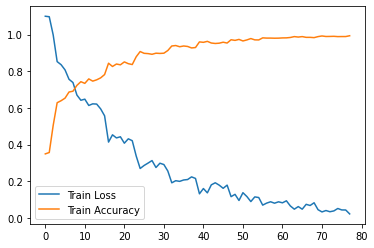

In [11]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

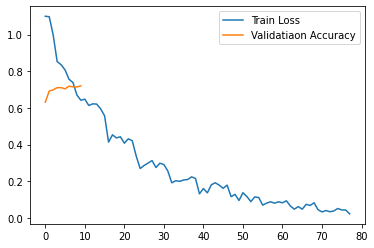

In [12]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [13]:
### 전체모델 저장
os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장(vocab)
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH,exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-ft-nli-0328/tokenizer_config.json',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-ft-nli-0328/special_tokens_map.json',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-ft-nli-0328/vocab.txt',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-ft-nli-0328/added_tokens.json')